# Improved DDPM Inpainting — Quantitative Evaluation

This notebook evaluates `improved_inpaint.py` (RePaint resampling + Gaussian soft mask) on **N images**
from the **MS COCO val2017** dataset, using **MNIST digit silhouettes** as masks (~10% of image).

Results are directly comparable to `Vanilla-Inpainting-Demo.ipynb` — both notebooks use the **same
SEED and N_IMAGES**, so they sample identical COCO images and MNIST digits.

**Output layout:**
```
eval_results_improved/
  originals/            ← 0000.png + 0000.json … (written once)
  inpainted/            ← 0000.png … 0099.png
  masks/                ← 0000.pt  … 0099.pt
  checkpoint.json
  metric_distributions.png  ← KDE overlay (improved vs vanilla)
  top10_best.png
  top10_worst.png
```


In [10]:
import sys, os, warnings
import torch
import numpy as np
warnings.filterwarnings("ignore", message="IProgress not found")
from tqdm.auto import tqdm
from utils import (
    load_data, prepare_mnist_mask, prepare_coco_image, apply_mask_for_display,
    run_metrics,
    load_checkpoint, save_checkpoint,
    print_stats_table, plot_kde_single, show_top10,
)

# ---- Config ----
N_IMAGES       = 500
IMAGE_SIZE     = (512, 512)
SEED           = 42
STEPS          = 50
GUIDANCE_SCALE = 7.5
DATA_ROOT      = './data'
RESAMPLE_STEPS = 5

RESULTS_DIR = './eval_results_improved'

os.makedirs(os.path.join(RESULTS_DIR, 'originals'), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'inpainted'), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'masks'),     exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f'Config: N_IMAGES={N_IMAGES}, SIZE={IMAGE_SIZE}, STEPS={STEPS}, GUIDANCE={GUIDANCE_SCALE}')
print(f'Output dir: {RESULTS_DIR}/inpainted')

Config: N_IMAGES=500, SIZE=(512, 512), STEPS=50, GUIDANCE=7.5
Output dir: ./eval_results_improved/inpainted


In [11]:
selected_ids, id_to_filename, captions, mnist, mnist_indices = load_data(
    DATA_ROOT, seed=SEED, n_images=N_IMAGES
)

coco_img_dir = os.path.join(DATA_ROOT, 'coco', 'val2017')
coco_samples = [
    (id_to_filename[img_id], captions[img_id][0])
    for img_id in selected_ids
]

COCO images already present: data/coco/val2017
COCO annotations already present: data/coco/annotations/captions_val2017.json
Valid images (excluding people/animals): 1591
MNIST dataset size: 10000
Sampled 500 image-mask pairs.


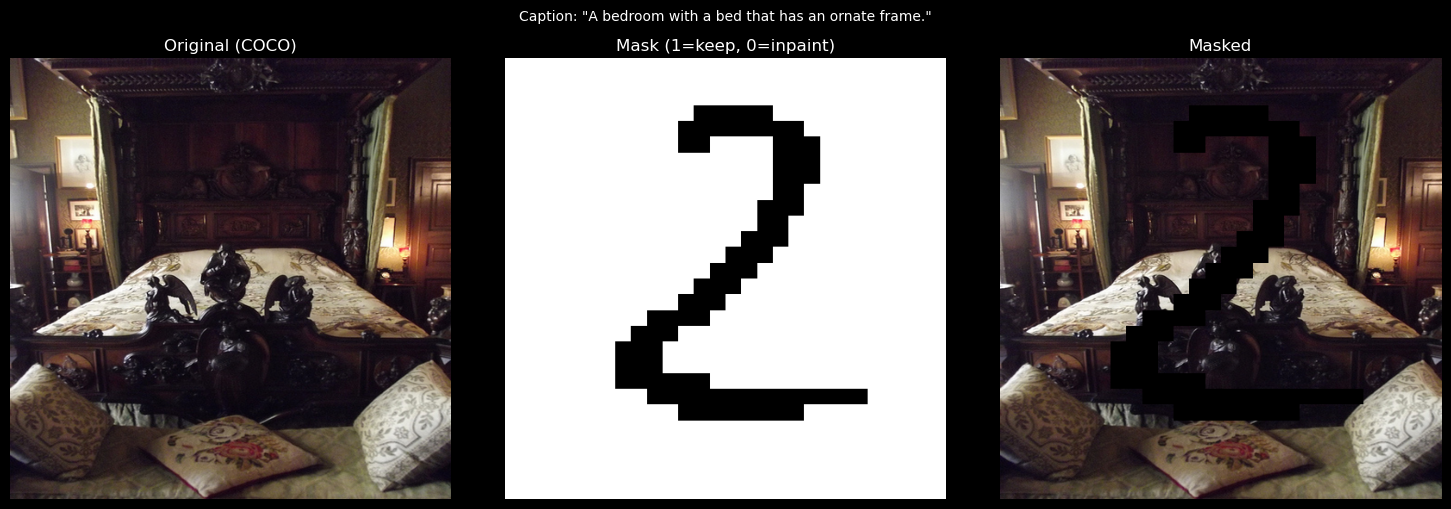

Inpainted region: 11.1% of image


In [12]:
import matplotlib.pyplot as plt

sample_filename, sample_caption = coco_samples[0]
sample_img   = prepare_coco_image(os.path.join(coco_img_dir, sample_filename))
sample_digit = mnist[mnist_indices[0]][0]
sample_mask  = prepare_mnist_mask(sample_digit)
sample_masked = apply_mask_for_display(sample_img, sample_mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_img);                          axes[0].set_title('Original (COCO)')
axes[1].imshow(sample_mask.squeeze(), cmap='gray');  axes[1].set_title('Mask (1=keep, 0=inpaint)')
axes[2].imshow(sample_masked);                       axes[2].set_title('Masked')
for ax in axes:
    ax.axis('off')
plt.suptitle(f'Caption: "{sample_caption}"', fontsize=10, y=1.01)
plt.tight_layout()
plt.show()

frac = (sample_mask == 0).float().mean().item() * 100
print(f'Inpainted region: {frac:.1f}% of image')

In [13]:
sys.path.insert(0, os.path.abspath('.'))
from improved_inpaint import ddpm_inpaint_improved
from utils.cli import load_sd_pipeline

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

print('Loading model...')
pipe = load_sd_pipeline(device)
pipe.set_progress_bar_config(disable=True)
print('Model loaded.')


Using device: mps
Loading model...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 24.15it/s]


Model loaded.


In [ ]:
INPAINTED_DIR = os.path.join(RESULTS_DIR, 'inpainted')
MASKS_DIR     = os.path.join(RESULTS_DIR, 'masks')
ORIGINALS_DIR = os.path.join(RESULTS_DIR, 'originals')

start_idx = load_checkpoint(RESULTS_DIR)

for i in tqdm(range(start_idx, N_IMAGES), initial=start_idx,
              total=N_IMAGES, desc='Improved inpainting'):
    filename, prompt = coco_samples[i]
    img_pil     = prepare_coco_image(os.path.join(coco_img_dir, filename))
    mask_tensor = prepare_mnist_mask(mnist[mnist_indices[i]][0])

    inpainted_pil = ddpm_inpaint_improved(
        pipe=pipe,
        image=img_pil,
        mask=mask_tensor,
        prompt=prompt,
        steps=STEPS,
        guidance_scale=GUIDANCE_SCALE,
        seed=SEED + i,
        resample_steps=RESAMPLE_STEPS,
    )

    orig_path = os.path.join(ORIGINALS_DIR, f'{i:04d}.png')
    if not os.path.exists(orig_path):
        img_pil.save(orig_path)
        import json
        with open(os.path.join(ORIGINALS_DIR, f'{i:04d}.json'), 'w') as jf:
            json.dump({'caption': prompt}, jf)

    inpainted_pil.save(os.path.join(INPAINTED_DIR, f'{i:04d}.png'))
    torch.save(mask_tensor, os.path.join(MASKS_DIR, f'{i:04d}.pt'))
    save_checkpoint(RESULTS_DIR, i + 1, prompt)

print(f'Done. Inpainted {N_IMAGES} images.')

Resuming from image 5


Improved inpainting:   1%|          | 5/500 [00:00<?, ?it/s]

In [ ]:
results = run_metrics(
    inpainted_dir=os.path.join(RESULTS_DIR, 'inpainted'),
    masks_dir=os.path.join(RESULTS_DIR, 'masks'),
    originals_dir=os.path.join(RESULTS_DIR, 'originals'),
    n_images=N_IMAGES,
    device=device,
)

print(f'Metrics computed for {len(results)} images.')


In [ ]:
print_stats_table(results, label='Improved DDPM Inpainting (RePaint + Negative Prompt + Bilinear Mask Downsampling)')

plot_kde_single(
    results,
    out_path=os.path.join(RESULTS_DIR, 'metric_distributions.png'),
    title='Improved DDPM Inpainting — Metric Distributions',
)


In [ ]:
show_top10(
    results,
    sort_by='lpips', ascending=True,
    out_path=os.path.join(RESULTS_DIR, 'top10_best.png'),
)


In [ ]:
show_top10(
    results,
    sort_by='lpips', ascending=False,
    out_path=os.path.join(RESULTS_DIR, 'top10_worst.png'),
)
